# Load libraries

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV

# Read train and test data

In [4]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [5]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.5
1,15.0,0.0,0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [6]:
meta = pd.read_csv('MetaData.csv')
print('Meta size:', meta.shape)
meta.head()

Meta size: (1330, 3)


,varnum,type,Column Type
0,V2,char,Numeric
1,V3,num,Category
2,V4,num,Category
3,V5,num,Category
4,V6,num,Category


# Replace all NaN's in train and test data to most frequent values in train data

In [7]:
Xbig = np.vstack((Xtrain, Xtest))

In [8]:
imp_first = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp_first.fit(Xbig)

Xtrain = imp_first.transform(Xtrain)
Xtest = imp_first.transform(Xtest)

# Train Random Forest classifier

In [40]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.2)

In [10]:
from sklearn.metrics import log_loss

In [37]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict_proba(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [38]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.60106557244
0.0519572910834
0.0517495664984
0.0514537395325
0.0513961773213
0.0513828600457
0.0512638292094
0.0511328573148
0.0510988170017
0.0511594456696
4.50688911495
0.21173282853
0.211313818925
0.211523484771
0.210701151274
0.210888996697
0.211539251658
0.211672304221
0.211092590602
0.211079159555


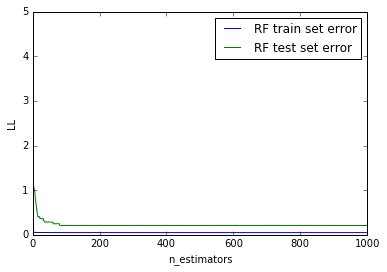

In [41]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=330, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

1.74853213832
0.052280792738
0.0521470820462
0.0518828478324
0.0518960859193
0.0519911687972
0.0520329356354
0.0521406587349
0.0521519859188
0.0520758559756
4.67537095102
0.218798154492
0.217089884366
0.215867639319
0.215930847105
0.215767027142
0.21645240872
0.215861903591
0.216142254697
0.215497263644


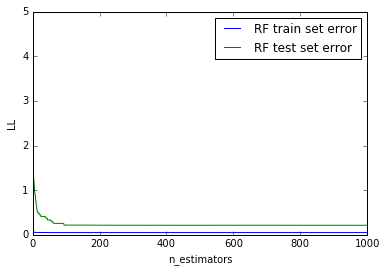

In [44]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=None, n_jobs=-1),
               X_train, X_test, y_train, y_test,
               prefix='RF')

In [45]:
clf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=None, n_jobs=-1)
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

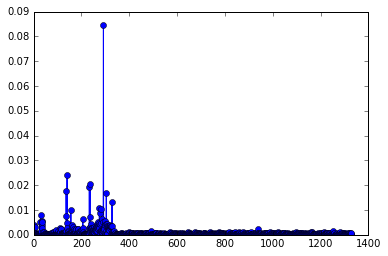

In [46]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plot(importances, '-o')

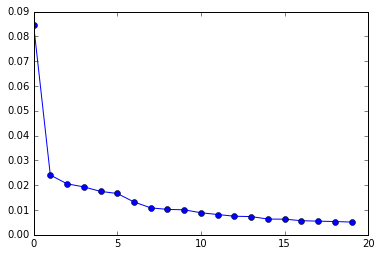

In [54]:
plot(importances[indices[0:20]], '-o')

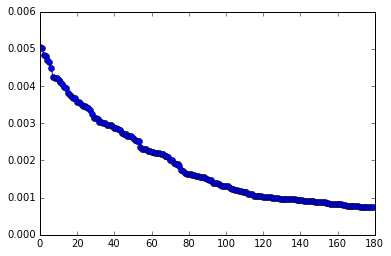

In [55]:
plot(importances[indices[20:200]], '-o')

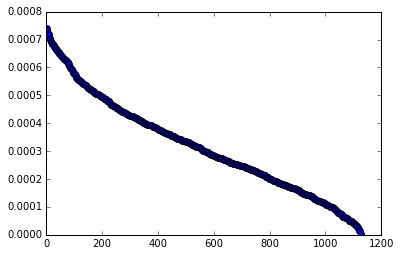

In [56]:
plot(importances[indices[200:]], '-o')

In [48]:
indices

array([292, 140, 236, ...,  43, 194,  46])

In [49]:
len(set(indices[:400]) - set(range(330)))

231

In [50]:
good_features = indices[:400]

1.68533218151
0.0515784211938
0.0511130451429
0.0512758846265
0.0512109056333
0.0511604445381
0.0511789268114
0.0511964202472
0.0512201420433
0.0511648935145
3.83296177065
0.287258846011
0.212493770736
0.210827191163
0.210783997664
0.21006315913
0.20964707575
0.209512761913
0.209276696146
0.209499685007


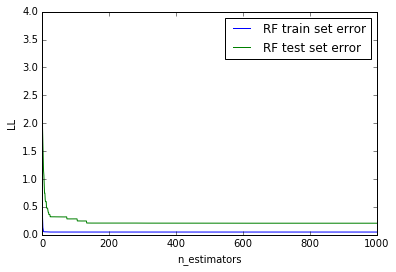

In [51]:
n_estimators = 1000
max_features = None
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy',\
                                        max_features=max_features, n_jobs=-1),
               X_train[:, good_features], X_test[:, good_features], y_train, y_test,
               prefix='RF')

In [57]:
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [62]:
%%time

best_score = 10
best_num = 0
scores = []
max_features = None

for num in range(100, 1000, 10):
    print(num)
    clf = RandomForestClassifier(n_estimators=1000, max_features=max_features, criterion='entropy', n_jobs=-1)
    clf.fit(X_train[:,indices[:num]], y_train)
    score = log_loss(y_test, clf.predict_proba(X_test[:,indices[:num]]))
    if score < best_score:
        best_score = score
        best_num = num
        print(best_num, best_score)
    scores.append((num, score))

print(best_score)
print(best_num)

100
100 0.210083430783
110
120
130
130 0.210011393033
140
140 0.209440732618
150
150 0.209144787195
160
170
180
190
200
210
210 0.208379511079
220
230
240
250
260
270
280
290
300
310
320
330
340
340 0.207936166927
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0.207936166927
340
CPU times: user 14h 7min 10s, sys: 23.1 s, total: 14h 7min 33s
Wall time: 3h 36min 48s


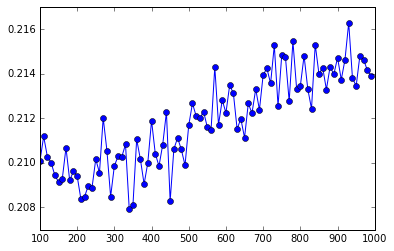

In [63]:
plot([x[0] for x in scores], [x[1] for x in scores], '-o')

In [64]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy',\
                                        max_features=max_features, n_jobs=-1)
clf.fit(Xtrain[:, indices[:best_num]], ytrain)

ypred = clf.predict_proba(Xtest[:, indices[:best_num]])[:, 1]

# Save predictions

In [65]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)